In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [7]:
#To obtain the Light Curve Data we search the MAST Database using lightkurve library.
import lightkurve as lk

In [8]:
#We read the RV datafile of TOI-2431.
df_rv_raw = pd.read_csv('../../data/rvdata/TIC 258804746_rv_bin.csv')

#We also add another column called "tel" to these DataFrames.
#This describes the instrument that was used to obtain these data.
df_rv_raw['tel'] = ['MERCATOR' for i in range(len(df_rv_raw))]

#We only take "bjd", "rv", "e_rv" and "tel" columns from the df_all as follows. (We basically remove other columns)
df_rv = df_rv_raw[['bjd','rv','e_rv','tel']]

#Then we define those columns as "time", "mnvel", "errvel" and "tel" as follows.
df_rv.columns = ['time','mnvel','errvel','tel']

df_rv

,time,mnvel,errvel,tel
0,2.460662e+06,-12.153412,2.790352,MERCATOR
1,2.460662e+06,-26.195315,3.368164,MERCATOR
2,2.460664e+06,-7.562243,2.513292,MERCATOR
3,2.460665e+06,1.563915,1.954405,MERCATOR
4,2.460666e+06,6.679098,1.907049,MERCATOR
5,2.460681e+06,-22.781483,4.561505,MERCATOR
6,2.460681e+06,-2.585665,3.008596,MERCATOR


In [9]:
t_rv = df_rv_raw.bjd.values
rv = df_rv_raw.rv.values
e_rv = df_rv_raw.e_rv.values

In [10]:
#We read the LC datafile of TOI-2431.
df_lc_raw = pd.read_csv('../../data/lcdata/TOI-2431_detrended.csv')

df_lc_raw

,time,flux,flux_err
0,2.459145e+06,1.001022,0.000797
1,2.459145e+06,0.999502,0.000797
2,2.459145e+06,1.000768,0.000797
3,2.459145e+06,1.000323,0.000797
4,2.459145e+06,1.000727,0.000797
...,...,...,...
73517,2.460259e+06,0.998395,0.000857
73518,2.460259e+06,1.000888,0.000858
73519,2.460259e+06,1.000695,0.000859
73520,2.460259e+06,1.000613,0.000860


In [11]:
t_lc = df_lc_raw.time.values
flux = df_lc_raw.flux.values
flux_err = df_lc_raw.flux_err.values

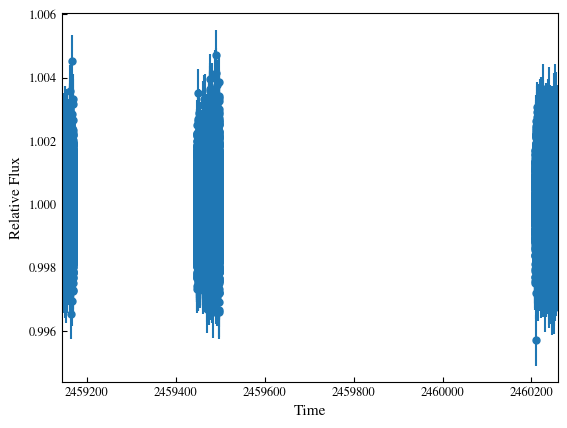

In [12]:
#Now we plot the Phase-Folded Light Curve.
#Note that we need to convert "MaskedNDArray" type into regular numpy arrays when it comes to plotting the errorbar.
#That's why, we use .filled(np.nan) for the "flux_err" Masked N-Dimension Array (MaskedNDArray).
plt.errorbar(t_lc, flux, flux_err, fmt="o")
plt.xlabel("Time", fontsize=11)
plt.ylabel("Relative Flux", fontsize=11)

#To see the transit more clear for this target, we limit x i.e. the time to maximum and minimum time value we have.
plt.xlim(min(t_lc),max(t_lc))
plt.show()

In [13]:
#For joint fitting to work, we need to define a dictionary that will store both LC and RV data.
inputdata = {}

#We add the RV times, velocities and velocity errors.
inputdata["time_rv1"] = df_rv.time.values
inputdata["rv_rv1"] = df_rv.mnvel.values
inputdata["e_rv1"] = df_rv.errvel.values

#We add the Transit times, fluxes and the flux errors.
inputdata["time_tr1"] = df_lc_raw.time.values
inputdata["f_tr1"] = df_lc_raw.flux.values
inputdata["e_tr1"] = df_lc_raw.flux_err.values

inputdata

{'time_rv1': array([2460661.69433389, 2460661.83431901, 2460663.81847674,
        2460664.63461718, 2460665.58386928, 2460680.64476996,
        2460680.74656597]),
 'rv_rv1': array([-12.15341225, -26.19531535,  -7.56224319,   1.56391486,
          6.67909776, -22.7814826 ,  -2.5856654 ]),
 'e_rv1': array([2.79035229, 3.3681642 , 2.51329169, 1.95440451, 1.90704861,
        4.56150459, 3.00859567]),
 'time_tr1': array([2459144.52044902, 2459144.52183793, 2459144.52322685, ...,
        2460259.40319537, 2460259.40458422, 2460259.40597308]),
 'f_tr1': array([1.00102236, 0.99950227, 1.00076793, ..., 1.00069548, 1.00061279,
        1.00060959]),
 'e_tr1': array([0.00079696, 0.00079656, 0.00079697, ..., 0.00085897, 0.00086042,
        0.0008615 ])}

In [14]:
#Now we import the GaiaRV source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafitwithtransit
import gaiasource
reload(gaiafitwithtransit)

gaiafitwithtransit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafitwithtransit' from '/home/kayahan/ExoSoft/notebooks/joint-fitting-tests/../../gaiafit/gaiafitwithtransit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/joint-fitting-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/joint-fitting-tests/../../gaiafit/utils.py'>)

In [15]:
#We get the Prior File for the target we are analyzing as follows.
#Please open one of the .txt files to see how to setup the Prior Files.
f = '../../data/lcrvpriors/TOI2431b_priorNewData.txt'
reload(gaiafitwithtransit)

#We then use "LPFunctionRVOnly" from the "gaiafit.py" code to do the fitting.
    #LPFunction => Likelihood Function
    #RVOnly => Tells you that it is only doing RV analysis, not Gaia Astrometric Analysis.

#Note that LPFunctionRVOnly plots the Priors.
L = gaiafitwithtransit.LPFunction1RV1Phot(inputdata,file_priors=f)

#We do a Gaia Fit for RV Only as follows. (Needs the Likelihood Function to work)
TF = gaiafitwithtransit.RMFit(L)

Reading in priorfile from ../../data/lcrvpriors/TOI2431b_priorNewData.txt
   prior          arg1          arg2        label  description priortype  \
0     NP  6.400000e-01  8.469820e-02        mstar        mstar     model   
1     NP  2.241958e-01  5.480000e-08         P_p1         P_p1     model   
2     FP  9.000000e+01  9.000000e+01       inc_p1       inc_p1     model   
3     UP  1.200000e+00  5.000000e+00         a_p1         a_p1     model   
4     NP  2.460259e+06  2.817369e-03        t0_p1        t0_p1     model   
5     FP  0.000000e+00  0.000000e+00       ecc_p1       ecc_p1     model   
6     FP  9.000000e+01  9.000000e+01     omega_p1     omega_p1     model   
7     NP  4.742543e-01  1.946948e-01         b_p1         b_p1     model   
8     NP  2.096097e-02  8.676171e-04         p_p1         p_p1     model   
9     NP  2.920000e-01  2.600000e-02      tdur_p1      tdur_p1     model   
10    UP  1.000000e-01  1.000000e+00           u1           u1     model   
11    UP  1.00

In [16]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=200,mc_iter=2000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
       labels       centers         lower         upper            pv   center_dist
0       mstar  6.400000e-01  2.165090e-01  1.063491e+00  2.351037e-01  4.048963e-01
1        P_p1  2.241958e-01  2.241955e-01  2.241961e-01  2.241956e-01  1.348918e-07
2        a_p1  3.100000e+00  1.200000e+00  5.000000e+00  2.644640e+00  4.553604e-01
3       t0_p1  2.460259e+06  2.460259e+06  2.460259e+06  2.460259e+06  1.112811e-02
4        b_p1  4.742543e-01 -4.992195e-01  1.447728e+00  5.637823e-01 -8.952801e-02
5        p_p1  2.096097e-02  1.662288e-02  2.529906e-02  2.311389e-02 -2.152925e-03
6     tdur_p1  2.920000e-01  1.620000e-01  4.220000e-01  3.408709e-01 -4.887091e-02
7          u1  5.500000e-01  1.000000e-01  1.000000e+00  1.137899e-01  4.362101e-01
8          u2  5.500000e-01  1.000000e-01  1.000000e+00  4.702034e-01  7.979657e-02
9        K_p1  2.500000e+01  0.000000e+00  5.000000e+01  2.137973e+01  3.620272e+00
10  gamma_rv1 

ValueError: Probability function returned NaN

In [ ]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [ ]:
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase. (?)
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

In [ ]:
#We calculate the Planet Mass using the posteriors K, Mstar, P and Eccentricity.
df_post['mp'] = utils.msini_from_rvs(df_post["K_p1"].values,
                                     m_1=0.640,
                                     P=df_post["P_p1"].values,
                                     e=0,
                                     i=90)

df_post["mp"]

In [ ]:
#We print out the median values as follows.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals[['Labels','values']]

In [ ]:
#We then plot the Corner Plot.
import corner
fig = corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

#We then need to access the figure axes in order to obtain the planet mass.
axes = fig.get_axes()

#Now we look for the planet mass using the titles of the corner plot.
mp_title = None
for ax in axes:
    title = ax.get_title() 
    if 'mp' in title:
        mp_title = title
        break

#We show the corner plot.
plt.show();

In [ ]:
#We again plot the Corner plot but this time with the Truths included to compare them with the values we have obtained from MCMC.
import corner
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
corner.corner(df_post.iloc[:, :-1].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :-1].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

In [ ]:
#We get the Mass from the MCMC chains to convert it to Earth Mass values.
# obj = [df_medvals[df_medvals.Labels=='mp']['values'].values[0]]
obj = mp_title

#We then extract the numbers and remove the $ and {} characters
cleaned_str = obj.replace('$', '').replace('{', '').replace('}', '').replace('_', '').replace('mp = ', '')

#Now we have to split the string by the symbols into central, lower, and upper values
central_value, lower_error, upper_error = cleaned_str.split('-')[0], cleaned_str.split('-')[1].split('+')[0], cleaned_str.split('+')[1]
lower_error = lower_error.replace('^', '')
upper_error = upper_error.replace('^', '')

#Now we convert all of them to floats and multiply them Earth Mass factor. (1 M_Jupiter = 317.83 M_Earth)
factor = 317.83
central_value = float(central_value) * factor
lower_error = float(lower_error) * factor
upper_error = float(upper_error) * factor

#We then format it back to the original string from the output.
mass_converted = f"${central_value:.3f}_{{-{lower_error:.3f}}}^{{+{upper_error:.3f}}}$"
print(mass_converted)

In [ ]:
NBIN = 2

#We get the P and T0 values from the MCMC results.
P = df_medvals.medvals.values[df_medvals.Labels=='P_p1'][0]
T_0 = df_medvals.medvals.values[df_medvals.Labels=='t0_p1'][0]

#We then define a function to convert observation times to the Orbital Phase.
def time_to_phase(times, P, T_0):
    """Takes the Observation Times, Period and the T0. Returns the orbital 
    phases for given Observation Times.
    
    Input:
    ----------------------------------------------------------------------------
    times: Array of observation times (Julian Dates)
    P: Orbital period in days
    T_0: Reference time (epoch or time of periastron) in Julian Date
    
    Output:
    ----------------------------------------------------------------------------
    ((times - T_0) % P) / P: Orbital Phases
    
    """
    
    #Normalize time to phase in the range [0, 1]
    return ((times - T_0 + 0.5 * P) % P) / P
    
#?????
t01 = gaiafitwithtransit.transit_time_from_ephem(inputdata['time_rv1'][0],P,T_0)
t02 = gaiafitwithtransit.transit_time_from_ephem(inputdata['time_tr1'][0],P,T_0)

#We define the data color, fit color and the transparency.
markercolor="black"
shadecolor="crimson"
ALPHA=0.4

#We then take the flattened chains.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#We define the times using the JD Times from the first and second dataset.
#Note that we define 500 time points.
times1 = np.linspace(TF.lpf.data_rv1['time'][0]-0.02,TF.lpf.data_rv1['time'][-1]+0.02,500)
times2 = np.linspace(TF.lpf.data_tr1['time'][0]-0.02,TF.lpf.data_tr1['time'][-1]+0.02,500)

#We convert the observation times from our data to the orbital phases.
phase1 = time_to_phase(TF.lpf.data_rv1["time"], P, T_0)
phase2 = time_to_phase(TF.lpf.data_tr1["time"], P, T_0)

#We define the 50th Percentile i.e. the Median by using the Flatchain we defined.
#The "[0]" is to get the percentiles out of the array and turn it into a list.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#?????
s1 = 0.
s2 = 0.

#We define times for the model/fit this time, using the minimum and maximum times.
#Note that we define 300 time points for the fit.
t1_mod = np.linspace(times1.min()-0.1,times1.max()+0.1,1000)
t2_mod = np.linspace(times2.min()-0.1,times2.max()+0.1,1000)

#We also convert the times for the model/fit to the orbital phases.
phase_model1 = time_to_phase(t1_mod, P, T_0)
phase_model2 = time_to_phase(t2_mod, P, T_0)

#We compute the Radial Velocities and Fluxes using 50th percentiles i.e. the Model.
rv_50_1, ff_50_1 = TF.lpf.compute_total_model(pv_50,times_rv1=t1_mod,times_tr1=t2_mod)

#We first sort our data according to the Phase values we have.
sorted_indices1 = np.argsort(phase_model1)
phase_model_sorted1 = phase_model1[sorted_indices1]
rv_50_1_sorted = rv_50_1[sorted_indices1]

sorted_indices2 = np.argsort(phase_model2)
phase_model_sorted2 = phase_model2[sorted_indices2]
ff_50_1_sorted = ff_50_1[sorted_indices2]

#?????
gamma1 = TF.lpf.get_jump_parameter_value(pv_50,'gamma_rv1')
#mflux = TF.lpf.get_jump_parameter_value(pv_50,'mflux_tr1')

#We define the Figure and the Axes.
#Note that we have two rows with one of them showing the RV and the other one showing the Residuals.
fig, (ax,bx) = plt.subplots(nrows=2,ncols=1,dpi=200,figsize=(9,7),sharex=True)

##################################
# Plot Radial Velocity Data
##################################

# ax.errorbar((TF.lpf.data_rv1['time']-t01)*24,TF.lpf.data_rv1['y'],np.sqrt(TF.lpf.data_rv1['error']**2.+s1**2.),
#             marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='RV')

ax.errorbar(phase1,TF.lpf.data_rv1['y'],np.sqrt(TF.lpf.data_rv1['error']**2.+s1**2.),
             marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='RV')
ax.plot(phase_model_sorted1,rv_50_1_sorted,color="crimson",
        label='Best-fit model',lw=2.,zorder=10)


##################################
# Plot Transit Data
##################################
# bx.errorbar((TF.lpf.data_tr1['time']-t02)*24,TF.lpf.data_tr1['y'],np.sqrt(TF.lpf.data_tr1['error']**2.+s2**2.),
#             marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='Flux')
bx.errorbar(phase2,TF.lpf.data_tr1['y'],np.sqrt(TF.lpf.data_tr1['error']**2.+s2**2.),
             marker='o',elinewidth=0.5,capsize=2,lw=0,mew=0.5,color=markercolor,markersize=4,alpha=ALPHA,label='Flux')
bx.plot(phase_model_sorted2,ff_50_1_sorted,color="crimson",
        label='Best-fit model',lw=2.,zorder=10)


#################
# Sample models ???????
#################
mmodel1 = []
mmodel2 = []
idx = np.random.choice(range(len(flatchain)),1000)
for i in range(1000):
    if i%100 == 0: print("Sampling, i=",i)
    #idx = #np.random.randint(0, flatchain.shape[0])
    m1,m2 = TF.lpf.compute_total_model(flatchain[idx[i]],times_rv1=t1_mod,times_tr1=t2_mod)
    mmodel1.append(m1)
    mmodel2.append(m2)
mmodel1 = np.array(mmodel1)
mmodel2 = np.array(mmodel2)


#ax.fill_between(phase_model_sorted1,np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),alpha=0.1,color=shadecolor,lw=0,zorder=-1)
#ax.fill_between((t1_mod-t01)*24.,np.quantile(mmodel1,0.02,axis=0),np.quantile(mmodel1,0.98,axis=0),alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
#ax.fill_between((t1_mod-t01)*24.,np.quantile(mmodel1,0.0015,axis=0),np.quantile(mmodel1,0.9985,axis=0),alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)

#bx.fill_between(phase_model_sorted2,np.quantile(mmodel2,0.16,axis=0),np.quantile(mmodel2,0.84,axis=0),alpha=0.1,color=shadecolor,lw=0,zorder=-1)
#bx.fill_between((t2_mod-t02)*24.,np.quantile(mmodel2,0.02,axis=0),np.quantile(mmodel2,0.98,axis=0),alpha=0.1,color=shadecolor,lw=0,label='2$\sigma$',zorder=-1)
#bx.fill_between((t2_mod-t02)*24.,np.quantile(mmodel2,0.0015,axis=0),np.quantile(mmodel2,0.9985,axis=0),alpha=0.1,color=shadecolor,lw=0,label='3$\sigma$',zorder=-1)
    
ax.set_ylabel("RV [m/s]",fontsize=18,labelpad=0)
bx.set_ylabel('Normalized Flux',fontsize=18,labelpad=1)
bx.set_xlabel('Phase',fontsize=18,labelpad=1)

ax.legend(loc='upper right',fontsize=12)

bx.legend(loc='lower right',fontsize=12)

fig.subplots_adjust(wspace=0.02,hspace=0.05,right=0.98,left=0.06,top=0.95,bottom=0.1)

plt.show();

In [ ]:
#Adding audio to know the fit has finished.
from IPython.display import Audio

beep = np.sin(2*np.pi*800*np.arange(3000*2)/100000)
Audio(beep, rate=100000, autoplay=True)